In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall 


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print(X.shape, y.shape)
X.head()

(569, 30) (569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# --- DEFINIÇÃO DA FUNÇÃO create_mlp 
def create_mlp(layers=1, neurons=16, activation='relu', dropout=0.2, optimizer='adam'):
    """Função que cria e compila um modelo Keras dinamicamente."""
    model = Sequential()
    # Camada de entrada com base no shape dos seus dados X
    model.add(Dense(neurons, input_shape=(X.shape[1],), activation=activation))
    model.add(Dropout(dropout))
    
    # Adiciona o número de camadas escondidas (layers) definido nos parâmetros
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout))
        
    # Camada de saída para classificação binária
    model.add(Dense(1, activation='sigmoid'))
    
    # Compila o modelo
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', Recall(name='recall')])
    return model

In [4]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numéricas:", list(num_cols))
print("Categóricas:", list(cat_cols))

Numéricas: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Categóricas: []


In [5]:
# Transformadores
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processador completo
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

X_processed = preprocessor.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier


param_dist = {
    'model__layers': [1, 2, 3],
    'model__neurons': [16, 32, 64],
    'model__activation': ['relu', 'tanh'],
    'model__dropout': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64], 
    'epochs': [20, 50]
}


mlp = KerasClassifier(model=create_mlp, verbose=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=10,
    cv=skf,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  
)


search.fit(X_train, y_train)

print("Melhores parâmetros:", search.best_params_)
print("Melhor acurácia média:", search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melhores parâmetros: {'model__optimizer': 'adam', 'model__neurons': 64, 'model__layers': 1, 'model__dropout': 0.4, 'model__activation': 'relu', 'epochs': 50, 'batch_size': 64}
Melhor acurácia média: 0.9802197802197803


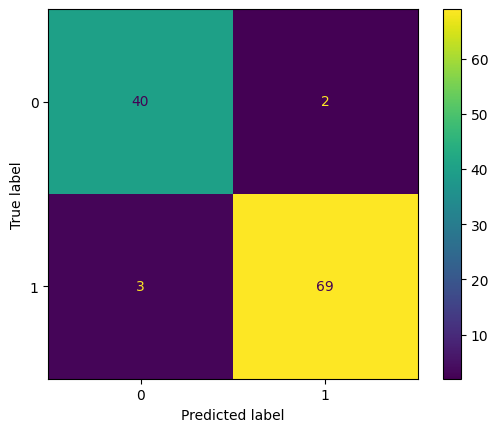

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.97      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Recall no teste: 0.9583


In [8]:
y_pred = search.best_estimator_.predict(X_test)

# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Recall detalhado
recall_value = recall_score(y_test, y_pred)
print(f"Recall no teste: {recall_value:.4f}")


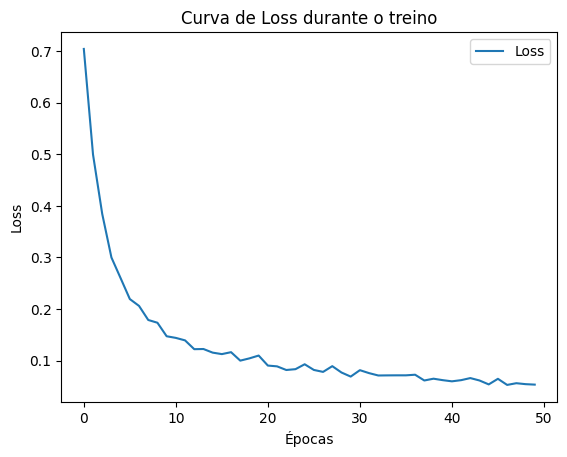

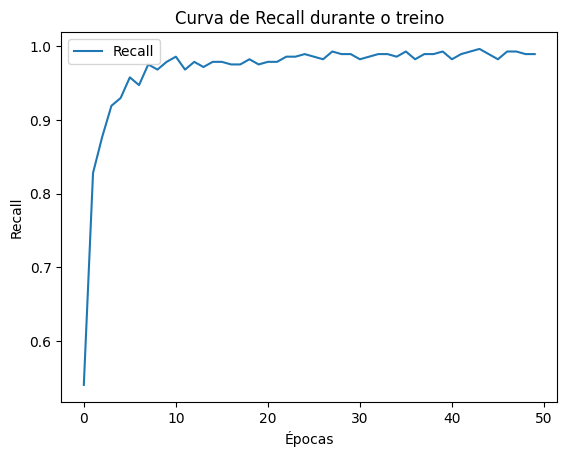

In [9]:
history = search.best_estimator_.model_.history

# Loss
plt.plot(history.history['loss'], label='Loss')
plt.title('Curva de Loss durante o treino')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Recall
plt.plot(history.history['recall'], label='Recall')
plt.title('Curva de Recall durante o treino')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.show()


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000141F6E48A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


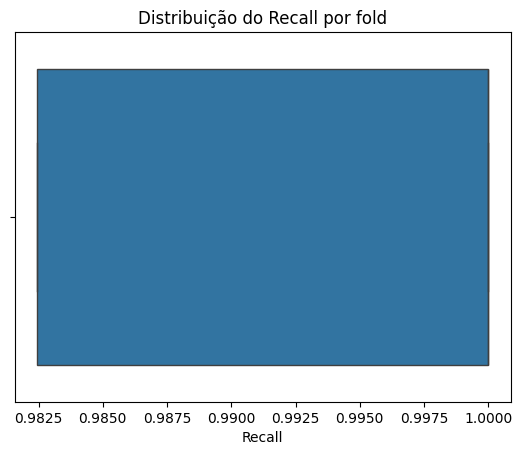


Recall médio: 0.9930


In [ ]:
cv_recalls = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
  
    best_params = search.best_params_
    
   
    model_args = {
        key.replace('model__', ''): value 
        for key, value in best_params.items() 
        if key.startswith('model__')
    }
    
   
    model_fold = create_mlp(**model_args)
    
    
    epochs = best_params['epochs']
    batch_size = best_params['batch_size']
    
    
    model_fold.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
    
    

    y_val_pred = (model_fold.predict(X_val) > 0.5).astype(int)
    cv_recalls.append(recall_score(y_val, y_val_pred))


sns.boxplot(x=cv_recalls) 
plt.title('Distribuição do Recall por fold')
plt.xlabel('Recall') 
plt.show()

print(f"\nRecall médio: {np.mean(cv_recalls):.4f}")
